In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Deactivate GPU JaX in local

from utils.costs_fn_metrics import explore_cost_fn

In [ ]:
from utils.datasets import emnist, celeba_attribute
(
    emnist_source_data,
    emnist_target_data,
    emnist_one_hot_src_labels,
    emnist_one_hot_tgt_labels,
) = emnist("train")

In [ ]:
import ott.geometry.costs as costs
from utils.ot_cost_fns import CoulombCost, HistCost

metrics, comparison_metrics = explore_cost_fn(
    X=emnist_source_data,
    labelX=emnist_one_hot_src_labels,
    Y=emnist_target_data,
    labelY=emnist_one_hot_tgt_labels,
    cost_fn=[
        costs.PNormP(p=1),
        costs.SqEuclidean(),
        HistCost(),
        costs.Euclidean(),
        costs.Cosine(),
        CoulombCost(),
        costs.ElasticL1(),
        costs.ElasticL2(),
        costs.ElasticSTVS(),
    ],
    sinkhorn_matching_kwargs=dict(
        tau_a=1.0,
        tau_b=1.0,
    ),
    nbatches=100,
    batch_size=256,
    summarize=True,
    save_folder=os.path.join("compare_cost_fn", "emnist_ot_batch256"),
    overwrite=True,
)

In [ ]:
import tensorflow as tf
import numpy as np

[x_train_cifar, y_train_cifar], [x_test_cifar, y_test_cifar] = (
    tf.keras.datasets.cifar10.load_data()
)


def one_hot_encode(labels: np.ndarray, num_classes: int):
    num_samples = labels.shape[0]
    encoded_labels = np.zeros((num_samples, num_classes), dtype=int)
    encoded_labels[np.arange(num_samples), labels.flatten()] = 1
    return encoded_labels

In [ ]:
import ott.geometry.costs as costs
from utils.ot_cost_fns import CoulombCost, HistCost

metrics, comparison_metrics = explore_cost_fn(
    X=np.transpose(x_train_cifar, (0, 3, 1, 2)),
    labelX=one_hot_encode(y_train_cifar, 10),
    cost_fn=[
        costs.SqEuclidean(),
        HistCost(),
        costs.PNormP(p=1),
        costs.Euclidean(),
        costs.Cosine(),
        CoulombCost(),
        costs.ElasticL1(),
        costs.ElasticL2(),
        costs.ElasticSTVS(),
    ],
    sinkhorn_matching_kwargs=dict(
        tau_a=1.0,
        tau_b=1.0,
    ),
    nbatches=50,
    batch_size=256,
    summarize=True,
    save_folder=os.path.join("compare_cost_fn", "cifar_ot_batch256"),
    overwrite=True,
)

# Celeba256

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # Deactivate GPU JaX in local

from utils.datasets import celeba_attribute
import matplotlib.pyplot as plt

/home/icb/pablo.acuavivahuerto/miniconda3/envs/uot-fm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf
import numpy as np
def central_crop(image: tf.Tensor, size: int) -> tf.Tensor:
    """Crop the center of an image to the given size."""
    top = (image.shape[0] - size) // 2
    left = (image.shape[1] - size) // 2
    return tf.image.crop_to_bounding_box(image, top, left, size, size)

def process_ds(x: np.ndarray) -> tf.Tensor:
    x = tf.cast(x, tf.float32) / 127.5 - 1.0
    x = tf.image.resize(x, [313, 256], antialias=True)
    x = central_crop(x, size=256)
    x = tf.transpose(x, perm=[2, 0, 1])
    return x

In [3]:
from typing import Tuple, Callable
import jax
import jax.experimental.mesh_utils as mesh_utils
import jax.sharding as sharding
from diffusers import FlaxAutoencoderKL
import jax.numpy as jnp


def get_vae_fns(shard: jax.sharding.Sharding) -> Tuple[Callable, Callable]:
    fx_path = "CompVis/stable-diffusion-v1-4"
    vae, vae_params = FlaxAutoencoderKL.from_pretrained(
        fx_path, subfolder="vae", revision="flax", dtype=jnp.float32
    )
    # replicate vae params across all devices
    vae_params = jax.device_put(vae_params, shard.replicate())

    @jax.jit
    def encode_fn(image_batch: jax.Array) -> jax.Array:
        latent_out = vae.apply({"params": vae_params}, image_batch, method=vae.encode)
        latent = latent_out.latent_dist.mode()
        latent = (latent * vae.config.scaling_factor).transpose(0, 3, 1, 2)
        return jax.lax.with_sharding_constraint(latent, shard)

    @jax.jit
    def decode_fn(latent_batch: jax.Array) -> jax.Array:
        image_out = vae.apply(
            {"params": vae_params},
            latent_batch / vae.config.scaling_factor,
            method=vae.decode,
        )
        return jax.lax.with_sharding_constraint(image_out.sample, shard)

    return encode_fn, decode_fn

100%|██████████| 256/256 [00:04<00:00, 60.88it/s]


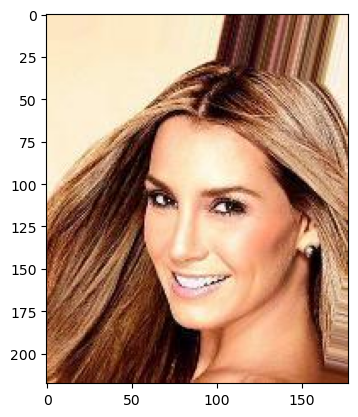

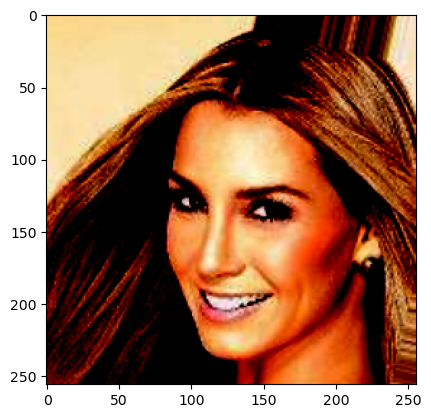

In [4]:
# Load normal dataset 
N = 256
celebaX, celebaY, _, _ = celeba_attribute(
    split='train',
    attribute_id=15,
    map_forward=True,
    batch_size=256,
    overfit_to_one_batch = False,
    nsamples = N,
)

plt.imshow(celebaX[0])
plt.show()
plt.imshow(np.transpose(process_ds(celebaX[0]), (1,2,0)))

# We need to transpose to get it into correct format for plotting (as explore internally transposes to get them all into the format)
celebaX = celebaX.transpose(0, 3, 1, 2)
celebaY = celebaY.transpose(0, 3, 1, 2)

In [5]:
num_devices = len(jax.devices())
# shard needs to have same number of dimensions as the input
devices = mesh_utils.create_device_mesh((num_devices, 1, 1, 1))
shard = sharding.PositionalSharding(devices)
vae_encode_fn, vae_decode_fn = get_vae_fns(shard)

# Load embedded dataset
celeba_embX, celeba_embY, celeba_labelX, celeba_labelY = celeba_attribute(
    split='train',
    attribute_id=15,
    map_forward=True,
    batch_size=256,
    overfit_to_one_batch = False,
    nsamples = N,
    vae_encode_fn = vae_encode_fn,
    preprocess_fn = process_ds,
)

celeba_labelX[celeba_labelX == -1] = 0
celeba_labelY[celeba_labelY == -1] = 0

  0%|          | 0/2 [00:00<?, ?it/s]2024-04-21 18:14:12.673922: W external/tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 36.02GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-04-21 18:14:23.216217: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f32[128,128,256,256]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,128,256,256]{3,2,1,0}, f32[128,128,3,3]{3,2,1,0}, f32[128]{0}, f32[128,128,256,256]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":1,"leakyrelu_alpha":0} is taking a while...
2024-04-21 18:14:23.220948: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.00485172s
Trying algorithm 

In [6]:
celeba_embX.shape

(256, 4, 32, 32)

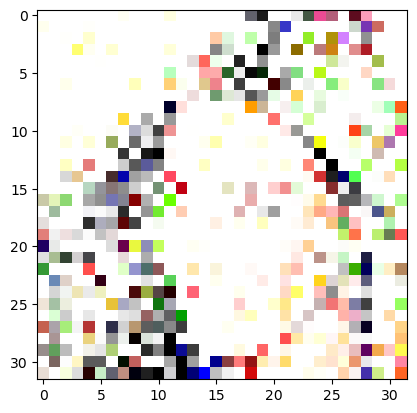

In [7]:
plt.imshow(np.transpose(celeba_embX[0,:,:,:], (1,2,0)))

In [ ]:
from utils.costs_fn_metrics import explore_cost_fn
import ott.geometry.costs as costs
from utils.ot_cost_fns import CoulombCost, HistCost

metrics, comparison_metrics = explore_cost_fn(
    X=celeba_embX,
    labelX=celeba_labelX,
    Y=celeba_embY,
    labelY=celeba_labelY,
    cost_fn=[
        costs.SqEuclidean(),
        HistCost(),
        costs.PNormP(p=1),
        costs.Euclidean(),
        costs.Cosine(),
        CoulombCost(),
        costs.ElasticL1(),
        costs.ElasticL2(),
        costs.ElasticSTVS(),
    ],
    sinkhorn_matching_kwargs=dict(
        tau_a=1.0,
        tau_b=1.0,
    ),
    nbatches=50,
    batch_size=256,
    summarize=True,
    save_folder=os.path.join("compare_cost_fn", "celeba_ot_batch256"),
    overwrite=True,
    decodedX=celebaX, 
    decodedY=celebaY,
)